This kernel present how to use VAE(Variational Auto-Encoder) to generate different MNIST images. VAE use convolution layers in encoder and decoder.

In [ ]:
import keras
from keras.layers import *
from keras.models import *
from keras.losses import *
from keras.callbacks import *
from keras.optimizers import *
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

# Check GPU setup in Colab
%tensorflow_version 2.x 
import tensorflow as tf
# Silence the tensorflow warning message
tf.get_logger().setLevel('ERROR')

print("Tensorflow version: ", tf.__version__)
print(tf.test.gpu_device_name())
# Your expected output will be '/device:GPU:0'

tf.compat.v1.disable_eager_execution()

Tensorflow version:  2.3.0
/device:GPU:0


## *1. Introduction*
Variational Autoencoders (VAEs) can be used to visualize high-dimensional data in a meaningful, lower-dimensional space. In this kernel, I go over some details about autoencoding and autoencoders, especially VAEs, before constructing and training a deep VAE on the MNIST data from the Digit Recognizer competition. We'll see how the data cluster in the lower-dimensional space according to their digit class. Plotting the test set data in this space shows where the images with unknown digit classes fall with respect to the known digit classes.

The code here borrows heavily from Fran&ccedil;ois Chollet's example VAE from his book [Deep Learning with Python](https://www.amazon.com/Deep-Learning-Python-Francois-Chollet/dp/1617294438/ref=sr_1_1?ie=UTF8&qid=1520470984&sr=8-1&keywords=francois+chollet). You can find a repo of examples from the book (including the one that inspired this kernel) [here on GitHub](https://github.com/brilliantFire/deep-learning-with-python-notebooks).

### *A. What is autoencoding?*
Autoencoding is much like what it sounds in the sense that the input and 'output' are essentially the same. It's an algorithm for data compression where the functions for compression and decompression are *learned from the data*. It's considered more of a *semi-supervised* learning method as opposed to a truly *unsupervised* one since it's not entirely 'targetless'. Instead it learns the targets from the data itself.

Despite all this talk of data compression, autoencoders aren't typically used for that purpose. In practice, you're much more likely to see them being used to preprocess data (as in denoising - think images but it doesn't have to be ;) ) or for dimensionality reduction. In fact, the hidden layers of simple autoencoders are doing something like principal component analysis (PCA), another method traditionally used for dimensionality reduction.

### *B. Autoencoders*
Generally autoencoders have three parts: an encoder, a decoder, and a 'loss' function that maps one to the other. For the simplest autoencoders - the sort that compress and then reconstruct the original inputs from the compressed representation - we can think of the 'loss' as describing the amount of information lost in the process of reconstruction. Typically when people are talking about autoencoders, they're talking about ones where the encoders and decoders are neural networks (in our case deep convnets). In training the autoencoder, we're optimizing the parameters of the neural networks to minimize the 'loss' (or distance) and we do that by stochastic gradient descent (yet another topic for another post). 

### *C. The Variational Variety*
There's a bunch of different kinds of autoencoders but for this post I'm going to concentrate on one type called a *variational autoencoder*. Variational autoencoders (VAEs) don't learn to morph the data in and out of a compressed representation of itself like the 'vanilla' autoencoders I described above. Instead, they learn the parameters of the probability distribution that the data came from. These types of autoencoders have much in common with latent factor analysis (if you know something about that). The encoder and decoder learn models that are in terms of underlying, unobserved *latent* variables. It's essentially an inference model and a generative model daisy-chained together.

![A variational autoencoder](https://i.imgur.com/ZN6MyTx.png)

VAEs have received a lot of attention because of their *generative* ability (though they seem to be falling out of fashion in favor of general adversarial networks, or GANs, in that regard). Since they learn about the distribution the inputs came from, we can sample from that distribution to generate novel data. As we'll see, VAEs can also be used to cluster data in useful ways.

## Load MNIST

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
# Only get some data to train and test
train_len = 60000
test_len = 10000
x_train = np.reshape(x_train[:train_len], [-1, image_size, image_size, 1])
x_test = np.reshape(x_test[:test_len], [-1, image_size, image_size, 1])
x_train = x_train.reshape(-1, 28, 28).astype('float32') / 255
x_test = x_test.reshape(-1, 28, 28).astype('float32') / 255
y_test = y_test[:test_len]
y_train = y_train[:train_len]

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Create 2 virtual GPUs with 1GB memory each
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024),
         tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPU, 2 Logical GPUs


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
# Change working directory to be current folder
# os.chdir('/content/gdrive/My Drive/Your Folder Name/Your sub Folder Name')
os.chdir('/content/gdrive/My Drive/Colab Notebooks/case_study_2')
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
case_study_2_discriminator.ipynb  case_study_2_vae.ipynb  vae_mnist.h5


## Show MNIST images

y_train[20] =  4
y_train[500] =  3
y_train[3000] =  9
y_train[9000] =  6


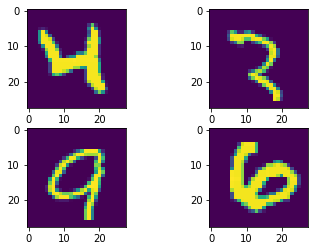

In [ ]:
x_train_show = x_train.reshape(-1,28,28)
plt.figure(1)
plt.subplot(221)
plt.imshow(x_train_show[20])
print('y_train[20] = ', y_train[20])

plt.subplot(222)
plt.imshow(x_train_show[500])
print('y_train[500] = ', y_train[500])

plt.subplot(223)
plt.imshow(x_train_show[3000])
print('y_train[3000] = ', y_train[3000])

plt.subplot(224)
plt.imshow(x_train_show[9000])
print('y_train[9000] = ', y_train[9000])
plt.show()

## 3. *Model construction*
### *A. Encoder network*
A VAE has three basic parts:  

1. An encoder that that learns the parameters (mean and variance) of the underlying latent distribution;  
2. A means of sampling from that distribution; and,  
3. A decoder that can turn the sample from #2 back into an image.  

In this example, both the encoder and decoder networks are deep convnets. You'll notice that the encoder below has two output layers, one for the latent distribution mean (z_mu) and the other for its variance (z_log_sigma).

### *B. Sampling function*
Next, we create a function to sample from the distribution we just learned the parameters of. `epsilon` is a tensor of small random normal values. One of the assumptions underlying a VAE like this is that our data arose from a random process and is normally distributed in the latent space.

With Keras, everything has to be in a 'layer' to compile correctly. This goes for our sampling function. The `Lambda` layer wrapper let's us do this.

### *C. Decoder network*
The decoder is basically the encoder in reverse.

### *D. Loss*
We need one more thing and that's something that will calculate the unique loss function the VAE requires. Recall that the VAE is trained using a loss function with two components:  

1. 'Reconstruction loss' - This is the cross-entropy describing the errors between the decoded samples from the latent distribution and the original inputs.  
2. The Kullback-Liebler divergence between the latent distribution and the prior (this acts as a sort of regularization term).  

We define a custom layer class that calculates the loss. 

In [ ]:
def make_vae(latent_size, x, kl_coeff=1.0):
    encoder_input = Input((28,28,))
    x = Reshape((28,28,1))(encoder_input)
    x = ZeroPadding2D(padding=2)(x)
    for n in [32,64,128,128,128]:
        x = Conv2D(n, kernel_size=3, padding='same')(x)
        x = Activation('relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=2)(x)
    x = Flatten()(x)
    z_mean = Dense(latent_size)(x)
    z_log_sigma = Dense(latent_size)(x)
    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=K.shape(z_mean),
                                  mean=0., stddev=1)
        return z_mean + K.exp(z_log_sigma) * epsilon

    z = Lambda(sampling, output_shape=(latent_size,))([z_mean, z_log_sigma])
    
    encoder = Model(encoder_input, z_mean)
    encoder.summary()

    decoder = Sequential()
    decoder.add(InputLayer((latent_size,)))
    decoder.add(Dense(128))
    decoder.add(Reshape((1,1,128)))
    for n in [128,128,64,32,1]:
        decoder.add(UpSampling2D(size=2))
        decoder.add(Conv2D(n, kernel_size=3, padding='same'))
        decoder.add(Activation('relu'))
        decoder.add(BatchNormalization())
    decoder.add(Conv2D(1, kernel_size=3, padding='same'))
    decoder.add(Activation('sigmoid'))
    decoder.add(Cropping2D(cropping=2))
    decoder.add(Reshape((28,28,)))
    decoder.summary()
    
    vae_output = decoder(z_mean)
    vae = Model(encoder_input, vae_output)
    vae.summary()
    
    def vae_loss(y_true, y_pred):
        recon_loss = K.sum(K.square(y_true-y_pred), axis=[1,2])
        kl_loss = - 0.5 * K.sum(1 + 2*z_log_sigma - K.square(z_mean) - K.square(K.exp(z_log_sigma)), axis=-1)
        return recon_loss + kl_coeff*kl_loss
    
    return encoder, decoder, vae, vae_loss

## Compile model

In [ ]:
encoder, decoder, vae, vae_loss = make_vae(2, x_train, kl_coeff=1.)

vae.compile(optimizer='rmsprop', loss=vae_loss, metrics=[])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)       

## Fit model

In [ ]:
!pip install livelossplot

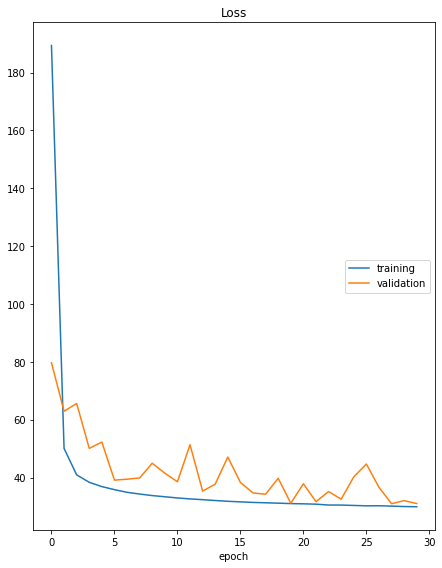

Loss
	training         	 (min:   29.902, max:  189.373, cur:   29.902)
	validation       	 (min:   30.946, max:   79.689, cur:   30.996)
60000/60000 [==============================] - 7s 119us/sample - loss: 29.9015 - val_loss: 30.9957


In [ ]:
epochs=30
batch_size=500
 
# train the autoencoder
from livelossplot import PlotLossesKeras
 
vae.fit(x_train, x_train, epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, x_test),
          callbacks = [PlotLossesKeras()])

In [ ]:
vae.save('vae_mnist.h5')

## Plot Results


#### A. Clustering of digits in the latent space
We can make predictions on the validation set using the encoder network. This has the effect of translating the images from the 784-dimensional input space into the 2-dimensional latent space. When we color-code those translated data points according to their known digit class, we can see how the digits cluster together.<br>


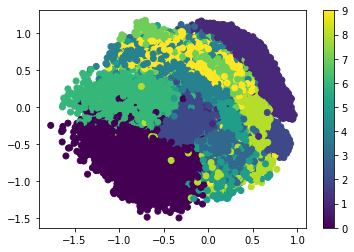

In [ ]:
encoded = encoder.predict(x_train)
encoded_t = encoded.T
plt.scatter(encoded_t[0], encoded_t[1],c=y_train,cmap='viridis')
plt.clim(0, 9)
plt.colorbar()


#### B. Reconstructing Digits
Autoencoder predictions are the compressed representations of the digits themselves.

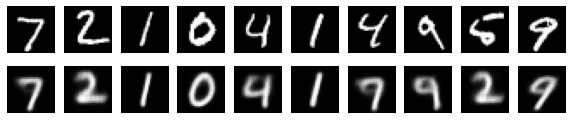

In [ ]:
plt.figure(figsize=(10,2))
x_pred = vae.predict(x_test[:10])

for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(x_test[i], cmap='gray')
    plt.axis('off')

for i in range(10):
    plt.subplot(2,10,10+i+1)
    plt.imshow(x_pred[i], cmap='gray')
    plt.axis('off')

### c. Generating Digits By Sampling From Latent Space

Another fun thing we can do is to use the decoder network to take a peak at what samples from the latent space look like as we change the latent variables. What we end up with is a smoothly varying space where each digit transforms into the others as we dial the latent variables up and down.

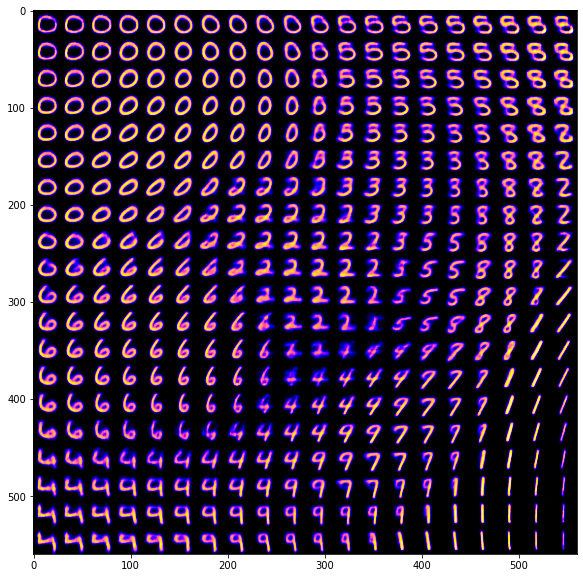

In [ ]:
from scipy.stats import norm

# Display a 2D manifold of the digits
n = 20  # figure with 20x20 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.1, 0.8, n))
grid_y = norm.ppf(np.linspace(0.1, 0.8, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        Z_sample = np.array([[xi, yi]])
        Z_sample = np.tile(Z_sample, batch_size).reshape(batch_size, 2)
        X_decoded = decoder.predict(Z_sample, batch_size=batch_size)
        digit = X_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gnuplot2')
plt.show()  

## Reference
> https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder_deconv.py